In [184]:
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import pandas as pd
import re
import networkx as nx
import shapely
import geopandas as gpd
import numpy as np

In [185]:
colors = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/colors.csv',delimiter=',')
elements = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/elements.csv',delimiter=',')
inventories = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/inventories.csv',delimiter=',')
inventory_minifigs = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/inventory_minifigs.csv',delimiter=',')
inventory_parts = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/inventory_parts.csv',delimiter=',')
inventory_sets = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/inventory_sets.csv',delimiter=',')
minifigs = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/minifigs.csv',delimiter=',')
part_categories = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/part_categories.csv',delimiter=',')
part_relationships = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/part_relationships.csv',delimiter=',')
parts = pd.read_csv(f'/Users/glover.co/Documents/laszlo/NetDesign/data/lego/rebrickable/parts.csv',delimiter=',')
sets = pd.read_csv(f'../../data/lego/rebrickable/sets.csv',delimiter=',')
themes = pd.read_csv(f'../../data/lego/rebrickable/themes.csv',delimiter=',')

In [186]:
def extract_sizes(name):
    match = re.search(r'(\d+)\s*[xX]\s*(\d+)(?:\s*[xX]\s*(\d+))?', name)
    if match:
        x, y, z = match.groups()
        return int(x), int(y), int(z) if z else 1  # Default z to 1
    return None, None, None 

In [202]:
parts[['x','y','z']] = parts['num_id'].apply(lambda name: pd.Series(extract_sizes(name)))

KeyError: 'num_id'

In [323]:
# def read_ldr(file):
#     """
#     Read a ldr file and return a list of brick names, 
#     a list of positions, and a list of rotation matrices

#     Parameters:
#         file (str): The path to the ldr file
    
#     Returns:
#         names (list) - names of bricks
#         positions (list) - positions of bricks
#         rotations (list) - rotation matrices of bricks
#     """
    
#     names = []
#     positions = []
#     rotations = []
#     with open(file, 'r') as f:
#         for line in f:
#             brick = line.strip('\n').split(' ')
#             if brick[0] == '1':
#                 if brick[-1][-1] != 'r':
#                     names.append(brick[-1][:-4])
#                     positions.append(brick[2:5])
#                     a,b,c = brick[5:8]
#                     d,e,f = brick[8:11]
#                     g,h,i = brick[11:14]
#                     rotations.append(np.array([[a,b,c],[d,e,f],[g,h,i]],dtype=float))
    
#     positions = np.array(positions,dtype=float)
                
#     return names, positions, rotations

In [505]:
import numpy as np

def parse_ldr_lines(lines):
    """
    Parses LDraw lines and extracts bricks and submodels.

    Parameters:
        lines (list): List of lines from an LDraw file.

    Returns:
        bricks (list): List of (name, position, rotation_matrix).
        submodels (dict): Dictionary of submodel names -> list of lines.
    """
    bricks = []
    submodels = {}
    current_submodel = None
    submodel_lines = []

    for line in lines:
        parts = line.strip().split()
        if len(parts) <= 1:  # Skip comments and meta commands
            continue
        if parts[0] == '0' and parts[1] == '!LPUB':
            continue
        if parts[:2] == ['0', 'FILE']:  # Start of a new submodel
            if current_submodel:  # Save the previous submodel
                submodels[current_submodel] = submodel_lines
            current_submodel = parts[2]
            submodel_lines = []
            continue
        
        if parts[0] == '0' and parts[1] == 'NOFILE':  # End of submodel
            if current_submodel:
                submodels[current_submodel] = submodel_lines
            current_submodel = None
            continue

        if current_submodel != 'model.ldr':  # Collecting submodel lines
            if parts[0] == '0' and parts[1] == 'STEP':
                continue
            else:
                submodel_lines.append(line)  # Store submodel lines
        
        else:
            if parts[0] == '1':  # Brick definition
                color = parts[1]
                pos = np.array(parts[2:5], dtype=float)
                rot = np.array(parts[5:14], dtype=float).reshape(3, 3)
                name = parts[14][:-4]

                bricks.append((name, pos, rot))

    return bricks, submodels


def apply_transformation(pos, rot, parent_pos, parent_rot):
    """
    Applies a transformation to a position and rotation.
    
    Parameters:
        pos (numpy array): Local position.
        rot (numpy array): Local rotation matrix.
        parent_pos (numpy array): Parent's global position.
        parent_rot (numpy array): Parent's global rotation matrix.
    
    Returns:
        (new_pos, new_rot): Transformed position and rotation matrix.
    """
    new_pos = parent_rot @ pos + parent_pos
    new_rot = parent_rot @ rot
    return new_pos, new_rot


def expand_submodels(bricks, submodels):
    """
    Replaces submodel references with actual bricks.

    Parameters:
        bricks (list): List of (name, position, rotation_matrix).
        submodels (dict): Dictionary of submodel names -> list of lines.

    Returns:
        expanded_bricks (list): Flattened list of all bricks with global positions.
    """
    expanded = []

    def process_brick(name, pos, rot):
        if f'{name}.ldr' in submodels: 
            # If it's a submodel, expand it
            sub_bricks, _ = parse_ldr_lines(submodels[f'{name}.ldr'])  # Get raw bricks inside
            for sub_name, sub_pos, sub_rot in sub_bricks:
                new_pos, new_rot = apply_transformation(sub_pos, sub_rot, pos, rot)
                process_brick(sub_name, new_pos, new_rot)  # Recursive expansion
        else:
            expanded.append((name, pos, rot))  # Normal brick

    for name, pos, rot in bricks:
        process_brick(name, pos, rot)  # Start processing

    return expanded



def read_ldr(file):
    """
    Reads an LDraw .ldr file and returns brick names, positions, and rotation matrices.

    Parameters:
        file (str): Path to the LDraw .ldr file.

    Returns:
        names (list): Brick names.
        positions (list): Brick positions.
        rotations (list): Rotation matrices.
    """
    with open(file, 'r') as f:
        lines = f.readlines()

    bricks, submodels = parse_ldr_lines(lines)
    expanded_bricks = expand_submodels(bricks, submodels)

    names, positions, rotations = zip(*expanded_bricks) if expanded_bricks else ([], [], [])
    return list(names), np.array(positions), np.array(rotations)


In [506]:
# read_ldr('/Users/glover.co/Documents/laszlo/NetDesign/data/lego/mepnet_data/classics_lpub3d/000012/model.ldr')
with open('/Users/glover.co/Documents/laszlo/NetDesign/data/lego/mepnet_data/classics_lpub3d/000012/model.ldr', 'r') as f:
    lines = f.readlines()
bricks, submodels = parse_ldr_lines(lines)
[n for n, p, r in bricks]
names, positions, rotations = read_ldr('/Users/glover.co/Documents/laszlo/NetDesign/data/lego/mepnet_data/classics_lpub3d/000012/model.ldr')

In [507]:
names

['3003',
 '3660',
 '3660',
 '3003',
 '3003',
 '3004',
 '3005',
 '3005',
 '3004',
 '3001',
 '3005',
 '3005',
 '3040b',
 '3040b',
 '3004',
 '3040b',
 '3040b',
 '2877',
 '3003',
 '85984',
 '2877',
 '2877',
 '2877',
 '2877']

In [392]:
def get_bounding_box(vertices):
    """
    Computes the 3D bounding box of a LEGO part.

    Parameters:
        vertices (list): A list of vertices of the LEGO part.

    Returns:
        tuple: A tuple containing the minimum and maximum coordinates of the bounding box.
    """
    min_x, min_y, min_z = np.min(vertices, axis=0)
    max_x, max_y, max_z = np.max(vertices, axis=0)
    
    return (min_x, min_y, min_z), (max_x, max_y, max_z)

In [393]:
def brick_size(name, parts):
    """
    Extracts the size of a LEGO part from its name.

    Parameters:
        name (str): The name of the LEGO part.
        parts (pd.DataFrame): A DataFrame containing information about LEGO parts.

    Returns:
        tuple: A tuple containing the size of the LEGO part.
    """
    size = parts[parts['name'] == name][['x', 'y', 'z']]
    return size


In [443]:
import numpy as np
import os

LDRAW_PATH = "/Users/glover.co/Downloads/ldraw/parts/"  # Update with your LDraw directory

def read_dat(file, visited=None):
    """
    Recursively reads a DAT file and extracts brick position and bounding box, including subparts.

    Parameters:
        file (str): The path to the DAT file.
        visited (set): Keeps track of visited files to avoid infinite recursion.

    Returns:
        top_vertices (numpy.ndarray): Top surface vertices.
        bottom_vertices (numpy.ndarray): Bottom surface vertices.
        bounding_box (tuple): ((xmin, ymin, zmin), (xmax, ymax, zmax)).
        size (tuple): (width, depth, height) in LDU.
    """
    if visited is None:
        visited = set()

    vertices = []
    faces = []
    edges = []

    if file in visited:
        return np.array([]), np.array([]), ((0, 0, 0), (0, 0, 0)), (0, 0, 0)  # Prevent infinite loops
    visited.add(file)

    if not os.path.exists(file):
        print(f"File not found: {file}")
        return np.array([]), np.array([]), ((0, 0, 0), (0, 0, 0)), (0, 0, 0)

    with open(file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts or parts[0] == '0':  # Ignore comments
                continue

            command_type = parts[0]

            if command_type == '1':  # Subpart reference
                subpart_name = parts[-1]
                # Replace backslashes with forward slashes for compatibility
                subpart_name = subpart_name.replace('\\', '/')
                subpart_file = os.path.join(LDRAW_PATH, subpart_name)

                # Recursively load subpart
                sub_top, sub_bottom, _, _ = read_dat(subpart_file, visited)
                vertices.extend(sub_top.tolist())
                vertices.extend(sub_bottom.tolist())

            elif command_type in {'2', '3', '4'}:  # Edge, Triangle, or Quad
                vertices_in_line = [tuple(map(float, parts[i:i+3])) for i in range(2, len(parts), 3)]
                for v in vertices_in_line:
                    if v not in vertices:
                        vertices.append(v)
                
                if command_type == '2':  # Edge
                    edges.append((vertices_in_line[0], vertices_in_line[1]))
                elif command_type == '3':  # Triangle
                    faces.append(tuple(vertices_in_line[:3]))
                elif command_type == '4':  # Quad
                    faces.append(tuple(vertices_in_line[:4]))

    if not vertices:
        return np.array([]), np.array([]), ((0, 0, 0), (0, 0, 0)), (0, 0, 0)

    # Convert to numpy array
    vertices = np.array(vertices)

    # Compute bounding box
    min_coords = np.min(vertices, axis=0)
    max_coords = np.max(vertices, axis=0)
    bounding_box = (tuple(min_coords), tuple(max_coords))
    size = tuple(max_coords - min_coords)  # (width, depth, height)

    print(f"Processed: {file}")
    print(f"Bounding Box: {bounding_box}")
    print(f"Calculated Size (LDU): Width={size[0]}, Depth={size[2]}, Height={size[1]}")

    # Separate top and bottom vertices based on height (Y-axis)
    ymin = min_coords[1]
    ymax = max_coords[1]
    min_idx = np.where(vertices[:, 1] == ymin)[0]
    max_idx = np.where(vertices[:, 1] == ymax)[0]
    top_vertices = vertices[max_idx]
    bottom_vertices = vertices[min_idx]

    return top_vertices, bottom_vertices, bounding_box, size


In [444]:
def apply_rotation(vertices, rotation_matrix, position):
    """
    Rotates and translates the brick's vertices.

    Parameters:
        vertices (list): A list of vertices of the brick.
        rotation_matrix (numpy.ndarray): A 3x3 rotation matrix.
        position (numpy.ndarray): A 1x3 position vector.
    
    Returns:
        numpy.ndarray: The rotated and translated vertices.
    """
    rotated = (rotation_matrix @ vertices.T).T  # Rotate
    return rotated + position  # Translate

In [524]:
def check_contact(box1, box2, min_overlap=0.1):
    """
    Check if two bounding boxes are in contact, i.e., one sits on top of the other.
    
    Parameters:
        box1, box2 (numpy.ndarray): Two bounding boxes, each as a 2x3 array where
                                     the first row is the (xmin, ymin, zmin) and
                                     the second row is the (xmax, ymax, zmax).
    
    Returns:
        bool: True if the two boxes are in contact, False otherwise.
    """
    # Unpack the bounding box coordinates for box1 and box2
    (xmin1, ymin1, zmin1), (xmax1, ymax1, zmax1) = box1
    (xmin2, ymin2, zmin2), (xmax2, ymax2, zmax2) = box2

    # Make shapely boxes
    box1 = shapely.geometry.box(xmin1, zmin1, xmax1, zmax1)
    box2 = shapely.geometry.box(xmin2, zmin2, xmax2, zmax2)

    # Check if the two boxes intersect
    if ymin1 == ymax2 or ymin2 == ymax1:
        intersection_area = box1.intersection(box2).area
        min_area = min(box1.area, box2.area)

        # Ensure the overlap is above a certain threshold
        if (intersection_area / min_area) >= min_overlap:
            return True
        
    return False

In [525]:
def find_contacting_boxes(bounding_boxes):
    """
    Find all pairs of bounding boxes that are in contact.
    
    Parameters:
        bounding_boxes (list of numpy.ndarray): A list of bounding boxes, each represented by a 2x3 array.
    
    Returns:
        list: A list of pairs of indices where the boxes are in contact.
    """
    contacting_pairs = []
    
    for i in range(len(bounding_boxes)):
        for j in range(i + 1, len(bounding_boxes)):
            if check_contact(bounding_boxes[i], bounding_boxes[j]):
                contacting_pairs.append((i, j))
    
    return contacting_pairs

In [545]:
def create_lego_network(file, with_names=True):
    """
    Create network from LDR lego model.
    This is done by reading the LDR file, extracting the bricks, and 
    finding the contacts between the bricks.

    Parameters:
        file (str): The path to the LDR file.
    
    Returns:
        networkx.Graph: A network representing the LEGO model.
    """
    # Read the LDR file
    names, positions, rotations = read_ldr(file)

    # Create a list of bounding boxes
    bounding_boxes = []
    for name, position, rotation in zip(names, positions, rotations):
        # Get the DAT file for the brick
        dat_file = os.path.join(LDRAW_PATH, f"{name}.dat")
        top_vertices, bottom_vertices, bounding_box, size = read_dat(dat_file)
        
        # Rotate and translate the vertices
        bounding_box = apply_rotation(np.array(bounding_box), rotation, position)
        
        bounding_boxes.append(bounding_box)
    
    # Find contacting boxes
    contacting_pairs = find_contacting_boxes(bounding_boxes)

    # Create a network
    G = nx.Graph()
    G.add_edges_from(contacting_pairs)

    # # Add brick name as node attribute
    # for i, name in enumerate(names):
    #     G.nodes[i]['name'] = name
    if with_names:
        # Make label matrix where each row is a node and each column is a name
        X = np.zeros((len(names),len(np.unique(names))))
        for i, name in enumerate(names):
            X[i,np.unique(names) == name] = 1
        return G, X
    return G

In [546]:
g, X =create_lego_network('/Users/glover.co/Documents/laszlo/NetDesign/data/lego/mepnet_data/classics_lpub3d/000012/model.ldr')

File not found: /Users/glover.co/Downloads/ldraw/parts/stud4.dat
File not found: /Users/glover.co/Downloads/ldraw/parts/box5.dat
File not found: /Users/glover.co/Downloads/ldraw/parts/box3u2p.dat
File not found: /Users/glover.co/Downloads/ldraw/parts/stug-2x2.dat
Processed: /Users/glover.co/Downloads/ldraw/parts/s/3003s02.dat
Bounding Box: ((-20.0, 24.0, -20.0), (20.0, 24.0, 20.0))
Calculated Size (LDU): Width=40.0, Depth=40.0, Height=0.0
Processed: /Users/glover.co/Downloads/ldraw/parts/s/3003s01.dat
Bounding Box: ((-20.0, 0.0, -20.0), (20.0, 24.0, 20.0))
Calculated Size (LDU): Width=40.0, Depth=40.0, Height=24.0
Processed: /Users/glover.co/Downloads/ldraw/parts/3003.dat
Bounding Box: ((-20.0, 0.0, -20.0), (20.0, 24.0, 20.0))
Calculated Size (LDU): Width=40.0, Depth=40.0, Height=24.0
File not found: /Users/glover.co/Downloads/ldraw/parts/stud3.dat
File not found: /Users/glover.co/Downloads/ldraw/parts/box5.dat
File not found: /Users/glover.co/Downloads/ldraw/parts/recte3.dat
File not 

In [547]:
X

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

In [542]:
int(len(np.unique(names)))

8

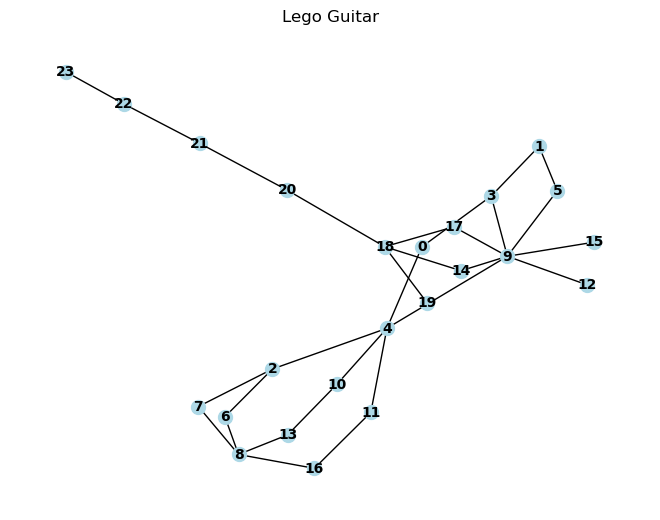

In [531]:
# Draw local neighborhood of node 0
pos = nx.spring_layout(g, seed=42)
# plt.figure(figsize=(6, 6))
neighborhood = nx.ego_graph(g, 13, radius=1)
nx.draw(g, pos, with_labels=True, node_size=100, node_color='lightblue', font_size=10, font_weight='bold')
plt.title('Lego Guitar')
plt.show()

In [1]:
g.number_of_nodes()

NameError: name 'g' is not defined

In [481]:
submodels['submodel_2.ldr']

['1 19 0.0 -24.0 0.0 -1.0000000000000004 0.0 4.440892098500627e-16 0.0 1.0 0.0 -4.440892098500627e-16 0.0 -1.0000000000000004 2877.dat\n',
 '1 5 -10.0 -48.0 0.0 1.0 0.0 2.220446049250313e-16 0.0 1.0 0.0 -2.220446049250313e-16 0.0 1.0 3005.dat\n',
 '1 5 10.0 -48.0 0.0 1.0 0.0 2.220446049250313e-16 0.0 1.0 0.0 -2.220446049250313e-16 0.0 1.0 3005.dat\n',
 '1 322 0.0 -72.0 0.0 1.0 0.0 2.220446049250313e-16 0.0 1.0 0.0 -2.220446049250313e-16 0.0 1.0 3004.dat\n',
 '1 322 10.0 -96.0 0.0 0.0 0.0 1.0000000000000002 0.0 1.0 0.0 -1.0000000000000002 0.0 0.0 3040b.dat\n']

In [249]:
brick = brick_names[0]
top, bottom, bounding_box0, size = read_dat(f'/Users/glover.co/Downloads/ldraw/parts/{brick}.dat')
bounding_box0 = apply_rotation(np.array(bounding_box0), rotations[0], positions[0])
brick = brick_names[1]
top, bottom, bounding_box1, size = read_dat(f'/Users/glover.co/Downloads/ldraw/parts/{brick}.dat')
bounding_box1 = apply_rotation(np.array(bounding_box1), rotations[1], positions[1])
brick = brick_names[2]
top, bottom, bounding_box2, size = read_dat(f'/Users/glover.co/Downloads/ldraw/parts/{brick}.dat')
bounding_box2 = apply_rotation(np.array(bounding_box2), rotations[2], positions[2])
brick = brick_names[3]
top, bottom, bounding_box3, size = read_dat(f'/Users/glover.co/Downloads/ldraw/parts/{brick}.dat')
bounding_box3 = apply_rotation(np.array(bounding_box3), rotations[3], positions[3])
brick = brick_names[4]
top, bottom, bounding_box4, size = read_dat(f'/Users/glover.co/Downloads/ldraw/parts/{brick}.dat')
bounding_box4 = apply_rotation(np.array(bounding_box4), rotations[4], positions[4])

File not found: /Users/glover.co/Downloads/ldraw/parts/stud4.dat
File not found: /Users/glover.co/Downloads/ldraw/parts/box5.dat
File not found: /Users/glover.co/Downloads/ldraw/parts/box3u2p.dat
File not found: /Users/glover.co/Downloads/ldraw/parts/stug-2x2.dat
Processed: /Users/glover.co/Downloads/ldraw/parts/s/3003s02.dat
Bounding Box: ((-20.0, 24.0, -20.0), (20.0, 24.0, 20.0))
Calculated Size (LDU): Width=40.0, Depth=40.0, Height=0.0
Processed: /Users/glover.co/Downloads/ldraw/parts/s/3003s01.dat
Bounding Box: ((-20.0, 0.0, -20.0), (20.0, 24.0, 20.0))
Calculated Size (LDU): Width=40.0, Depth=40.0, Height=24.0
Processed: /Users/glover.co/Downloads/ldraw/parts/3003.dat
Bounding Box: ((-20.0, 0.0, -20.0), (20.0, 24.0, 20.0))
Calculated Size (LDU): Width=40.0, Depth=40.0, Height=24.0
File not found: /Users/glover.co/Downloads/ldraw/parts/stud3.dat
File not found: /Users/glover.co/Downloads/ldraw/parts/box5.dat
File not found: /Users/glover.co/Downloads/ldraw/parts/recte3.dat
File not 

In [298]:
find_contacting_boxes([bounding_box0, bounding_box1, bounding_box2, bounding_box3, bounding_box4])


[(0, 3), (0, 4), (1, 3), (2, 4)]

In [299]:
check_contact(bounding_box0, bounding_box3)

True

In [206]:
bottom@rotations[1]

array([[ 30.,   4.,  20.],
       [ 30.,   4., -20.]])

In [207]:
top

array([[ 20.,  24., -10.],
       [-20.,  24., -10.]])

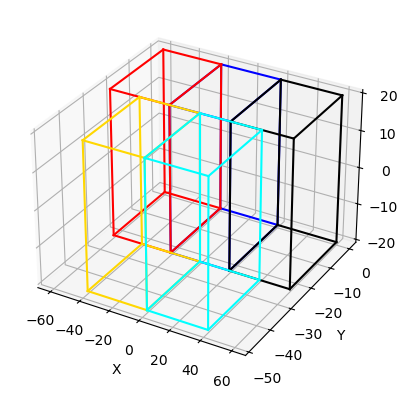

In [265]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_bounding_boxes(bounding_boxes, ax=None,colors=None):
    """
    Plots multiple 3D bounding boxes.

    Parameters:
        bounding_boxes (list): A list of tuples where each tuple is 
                                ((xmin, ymin, zmin), (xmax, ymax, zmax)) for each bounding box.
        ax (matplotlib.axes._subplots.Axes3DSubplot, optional): A matplotlib 3D axes object to plot the boxes. If None, one will be created.
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # Loop over each bounding box and plot it
    for j,bounding_box in enumerate(bounding_boxes):
        # Unpack bounding box coordinates
        (xmin, ymin, zmin), (xmax, ymax, zmax) = bounding_box

        # Define the 8 corners of the bounding box
        corners = [
            [xmin, ymin, zmin], [xmax, ymin, zmin], [xmax, ymax, zmin], [xmin, ymax, zmin],
            [xmin, ymin, zmax], [xmax, ymin, zmax], [xmax, ymax, zmax], [xmin, ymax, zmax]
        ]

        # Define the 12 edges by connecting corners
        edges = [
            [corners[0], corners[1]], [corners[1], corners[2]], [corners[2], corners[3]], [corners[3], corners[0]],
            [corners[4], corners[5]], [corners[5], corners[6]], [corners[6], corners[7]], [corners[7], corners[4]],
            [corners[0], corners[4]], [corners[1], corners[5]], [corners[2], corners[6]], [corners[3], corners[7]]
        ]

        # Plot the edges for each bounding box
        for edge in edges:
            if colors is None:
                ax.plot3D(*zip(*edge), color="b")
            else:
                ax.plot3D(*zip(*edge), color=colors[j])

        # Set plot limits to encompass all boxes
        # ax.set_xlim([min([b[0][0] for b in bounding_boxes]), max([b[1][0] for b in bounding_boxes])])
        # ax.set_ylim([min([b[0][1] for b in bounding_boxes]), max([b[1][1] for b in bounding_boxes])])
        # ax.set_zlim([min([b[0][2] for b in bounding_boxes]), max([b[1][2] for b in bounding_boxes])])

    # Set labels for clarity
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# Example list of bounding boxes: [((xmin, ymin, zmin), (xmax, ymax, zmax)), ...]
bounding_boxes = [bounding_box0,bounding_box1,bounding_box2,bounding_box3,bounding_box4]  # Third bounding box


# Plot the bounding boxes
plot_bounding_boxes(bounding_boxes,colors=['b','r','k','gold','cyan'])


In [266]:
bounding_boxes

[array([[-20., -24., -20.],
        [ 20.,   0.,  20.]]),
 array([[-60., -24.,  20.],
        [-20.,   0., -20.]]),
 array([[ 60., -24., -20.],
        [ 20.,   0.,  20.]]),
 array([[-40., -48., -20.],
        [  0., -24.,  20.]]),
 array([[  0., -48., -20.],
        [ 40., -24.,  20.]])]

In [282]:
bounding_box0

array([[-20., -24., -20.],
       [ 20.,   0.,  20.]])

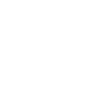

In [288]:
shapely.geometry.box(bounding_box0[0,0],bounding_box0[1,0],bounding_box0[0,2],bounding_box0[1,2])

In [289]:
shapely.geometry.box?

Signature: shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
Docstring: Returns a rectangular polygon with configurable normal vector
File:      ~/anaconda3/lib/python3.11/site-packages/shapely/geometry/geo.py
Type:      function